# Project 1 problem 5 & 6

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

fig_size = (4,4)
fsz = 10 # font size
plt.rcParams.update({'font.size': fsz})

In [2]:
# Polynomial interpolation with Chebyshev nodes extrema of T_{n}(x)

def Cheb_coeffs2(n,func):
    c = np.zeros((n+1,))
    t = (np.arange(n+1))*np.pi/n 
    for k in range(n+1):
        c[k] = 2*np.sum(func(np.cos(t))*np.cos(k*t))/n \
                  -func(np.cos(t[0]))*np.cos(k*t[0])/n \
                  -func(np.cos(t[-1]))*np.cos(k*t[-1])/n
    return c

def ChebSum2_Clenshaw_matrix(n,x,c):
    diagonals = [np.ones((n+1,)),-2*x*np.ones((n,)),np.ones((n-1,))]
    A = scipy.sparse.diags(diagonals,[0,-1,-2],shape=(n+1,n+1))
    A = A.toarray()
    b = scipy.linalg.solve_triangular(np.transpose(A),c,lower = False) # Upper-triangular solver
    return 0.5*(b[0] - b[2] - b[n]*np.cos(n*np.arccos(x)))
    
   

In [3]:
# Trefeten's cheb.m (see page 74 of PDF of [2]) rewritten in Python
def cheb(N):
    if N == 0:
        D = 0
        x = 1
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c = np.ones((N+1,))
    c[0] = 2
    c[N] = 2
    c[1::2] = -c[1::2]
    # create an (N+1)-by-(N+1) matrix whose columns are the vectors of Chebychev nodes
    X = np.zeros((N+1,N+1))
    for j in range(N+1):
        X[:,j] = x
    dX = X - np.transpose(X)
    D = np.outer(c,1/c)/(dX + np.eye(N+1)) # off-diagonal entries
    D = D - np.diag(np.sum(D,axis = 1)) # D[i,i] = -\sum_{j\neq i} D[i,j] 
    return D,x
    

## Problem 5

In [4]:
def u_exact(x):
    return np.cos(np.pi * x) + 1

def compute_g(x):
    # u_exact = cos(π*x) + 1
    # g(x) = cos(π*x)*(π⁴ + 4*π² + 3) + 3 
    coeff = np.pi**4 + 4*np.pi**2 + 3
    return coeff * np.cos(np.pi * x) + 3


In [5]:
def solve_fourth_order_bvp(N):
    """
    N: Number of Chebyshev extrema points
    x: Chebyshev extrema grid points
    u: Solution values at grid points
    """
    
    D, x = cheb(N)
    D2 = np.linalg.matrix_power(D, 2)  # second derivative
    D4 = np.linalg.matrix_power(D, 4)  # fourth derivative
    
    I = np.eye(N+1)
    L = D4 - 4*D2 + 3*I
    
    g = compute_g(x)
    
    # boundary conditions
    # u(1) = 0
    L[0, :] = 0; L[0, 0] = 1; g[0] = 0
    # u'(1) = 0
    L[1, :] = D[0, :]; g[1] = 0
    # u'(-1) = 0
    L[N-1, :] = D[N, :]; g[N-1] = 0 
    # u(-1) = 0
    L[N, :] = 0; L[N, N] = 1; g[N] = 0
    

    u = np.linalg.solve(L, g)
    
    return x, u


N_values = [10, 20, 40, 60]
solutions = {}

for N in N_values:
    x_cheb, u_cheb = solve_fourth_order_bvp(N)
    solutions[N] = (x_cheb, u_cheb)
    
    # Check boundary conditions
    u_1 = u_cheb[0]
    u_neg1 = u_cheb[N]
    
    print(f"N = {N:2d}: u(1) = {u_1:8.2e}, u(-1) = {u_neg1:8.2e}")


N = 10: u(1) = -2.72e-14, u(-1) = 0.00e+00
N = 20: u(1) = 1.27e-12, u(-1) = 0.00e+00
N = 40: u(1) = 1.65e-12, u(-1) = 0.00e+00
N = 60: u(1) = 2.12e-10, u(-1) = 0.00e+00


In [6]:
# evaluate using Clenshaw's method
def evaluate_solution_uniform_grid(N, n_uniform=1000):
    
    x_cheb, u_cheb = solve_fourth_order_bvp(N)
    

    n = N
    c = np.zeros(n+1)
    t = np.arange(n+1) * np.pi / n
    
    for k in range(n+1):
        c[k] = 2 * np.sum(u_cheb * np.cos(k * t)) / n
        if k > 0:
            c[k] -= u_cheb[0] * np.cos(k * t[0]) / n
            c[k] -= u_cheb[n] * np.cos(k * t[n]) / n
    
    # grid
    x_uniform = np.linspace(-1, 1, n_uniform)
    u_uniform = np.zeros(n_uniform)
    
    for j in range(n_uniform):
        u_uniform[j] = ChebSum2_Clenshaw_matrix(n, x_uniform[j], c)
    
    return x_uniform, u_uniform


uniform_solutions = {}

for N in N_values:
    x_uniform, u_uniform = evaluate_solution_uniform_grid(N, 1000)
    uniform_solutions[N] = (x_uniform, u_uniform)

    u_exact_uniform = u_exact(x_uniform)
    error = np.max(np.abs(u_uniform - u_exact_uniform))
    
    print(f"N = {N:2d}: Max error on uniform grid = {error:.2e}")


N = 10: Max error on uniform grid = 7.29e-05
N = 20: Max error on uniform grid = 1.31e-12
N = 40: Max error on uniform grid = 1.19e-11
N = 60: Max error on uniform grid = 2.13e-10


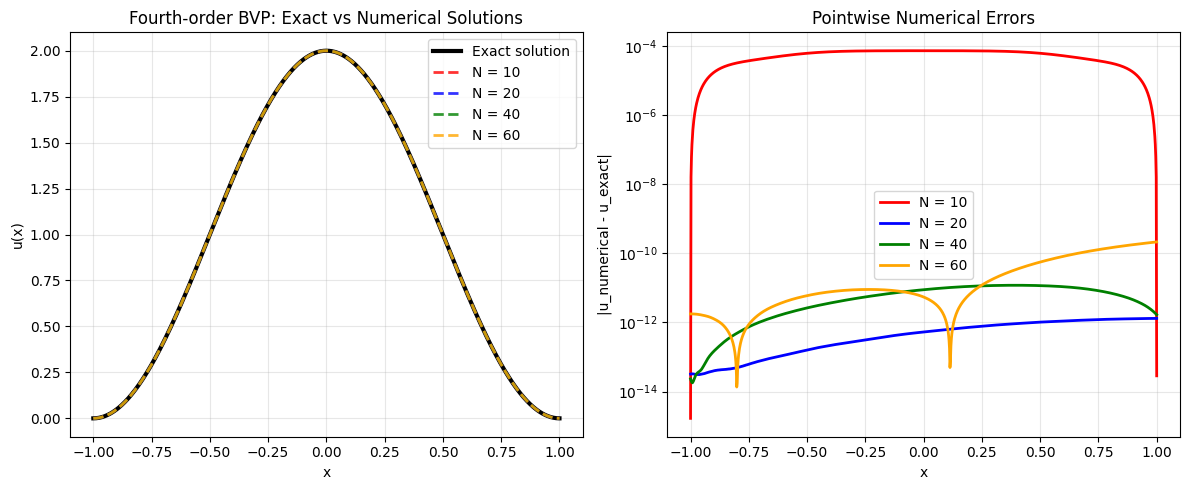

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# solutions comparison
x_plot = np.linspace(-1, 1, 1000)
u_exact_plot = u_exact(x_plot)

ax1.plot(x_plot, u_exact_plot, 'k-', linewidth=3, label='Exact solution')

colors = ['red', 'blue', 'green', 'orange']
for i, N in enumerate(N_values):
    x_uniform, u_uniform = uniform_solutions[N]
    ax1.plot(x_uniform, u_uniform, '--', color=colors[i], linewidth=2, 
             label=f'N = {N}', alpha=0.8)

ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')
ax1.set_title('Fourth-order BVP: Exact vs Numerical Solutions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# numerical errors
for i, N in enumerate(N_values):
    x_uniform, u_uniform = uniform_solutions[N]
    u_exact_uniform = u_exact(x_uniform)
    error = np.abs(u_uniform - u_exact_uniform)
    ax2.semilogy(x_uniform, error, color=colors[i], linewidth=2, 
                 label=f'N = {N}')

ax2.set_xlabel('x')
ax2.set_ylabel('|u_numerical - u_exact|')
ax2.set_title('Pointwise Numerical Errors')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figures/Fourth_order_BVP_solutions.pdf", bbox_inches='tight')
plt.show()


Convergence analysis:
N	Max Error	Reduction Factor
----------------------------------------
 8	3.17e-03	N/A
12	1.26e-06	2512.4
16	1.42e-10	8865.8
20	1.31e-12	108.9
24	1.12e-11	0.1
28	1.47e-11	0.8
32	1.41e-11	1.0
36	8.07e-12	1.7
40	1.19e-11	0.7
44	9.03e-11	0.1
48	5.32e-11	1.7
52	1.98e-10	0.3
56	1.37e-10	1.4
60	2.13e-10	0.6
64	2.16e-10	1.0


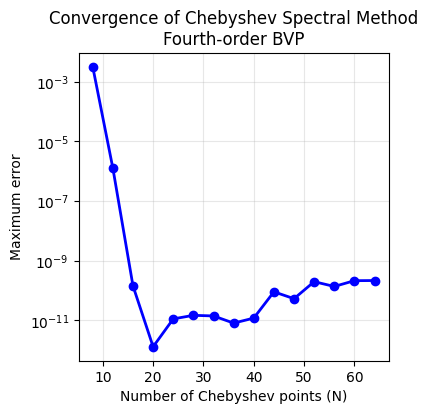

In [8]:
N_range = np.arange(8, 65, 4)
max_errors = []

print("Convergence analysis:")
print("N\tMax Error\tReduction Factor")
print("-" * 40)

prev_error = None
for N in N_range:
    try:
        x_uniform, u_uniform = evaluate_solution_uniform_grid(N, 1000)
        u_exact_uniform = u_exact(x_uniform)
        max_error = np.max(np.abs(u_uniform - u_exact_uniform))
        max_errors.append(max_error)
        
        reduction_factor = prev_error / max_error if prev_error is not None else None
        reduction_str = f"{reduction_factor:.1f}" if reduction_factor is not None else "N/A"
        
        print(f"{N:2d}\t{max_error:.2e}\t{reduction_str}")
        prev_error = max_error
        
    except np.linalg.LinAlgError:
        print(f"{N:2d}\tSingular matrix")
        max_errors.append(np.nan)

# plot
fig, ax = plt.subplots(figsize=fig_size)
valid_indices = ~np.isnan(max_errors)
ax.semilogy(N_range[valid_indices], np.array(max_errors)[valid_indices], 'bo-', linewidth=2, markersize=6)
ax.set_xlabel('Number of Chebyshev points (N)')
ax.set_ylabel('Maximum error')
ax.set_title('Convergence of Chebyshev Spectral Method\nFourth-order BVP')
ax.grid(True, alpha=0.3)

plt.savefig("Figures/Fourth_order_BVP_convergence.pdf", bbox_inches='tight')
plt.show()


## Problem 6

In [9]:
def u_exact_p6(x):
    return 1 / (1 + x**2)

def g_p6(x):
    """
    u(x) = 1/(1+x²)
    u'(x) = -2x/(1+x²)²
    u''(x) = (6x² - 2)/(1+x²)³  
    u'''(x) = 24x(1-x²)/(1+x²)⁴
    u⁽⁴⁾(x) = 24(5x⁴ - 10x² + 1)/(1+x²)⁵
    g(x) = u⁽⁴⁾(x) + u'(x) + u(x)
    """
    x2 = x**2
    denom1 = (1 + x2)
    denom2 = denom1**2
    denom5 = denom1**5
    
    u = 1 / denom1
    u_prime = -2*x / denom2
    u_fourth = 24*(5*x2**2 - 10*x2 + 1) / denom5
    
    return u_fourth + u_prime + u


In [10]:
def solve_fourth_order_bvp_p6(N):
    """
    scale to [-1,1]: x ∈ [-1,1], z ∈ [0,5], z = 2.5 + 2.5x
    decompose: u = v + b, v satisfies homogeneous BCs
    """
    
    D, x = cheb(N)

    D2 = np.linalg.matrix_power(D, 2)
    D4 = np.linalg.matrix_power(D, 4)
    
    # Scale from [-1,1] to [0,5]
    scale = 2.5
    shift = 2.5
    z = shift + scale * x
    
    
    # boundary conditions
    u_0 = 1
    u_5 = 1/26
    up_0 = 0
    up_5 = -10/676
    
    # u'(z) = (1/scale) * w'(x), w'(x) = scale * u'(z)
    wp_minus1 = scale * up_0
    wp_plus1 = scale * up_5
    

    def p0(x):
        return (x - 1)**2 * (x + 2) / 4
    
    def p1(x): 
        return (x + 1)**2 * (2 - x) / 4
    
    def q0(x):
        return (x - 1)**2 * (x + 1) / 4
    
    def q1(x):
        return (x + 1)**2 * (x - 1) / 4
    
    b = u_0 * p0(x) + u_5 * p1(x) + wp_minus1 * q0(x) + wp_plus1 * q1(x)
    
    b_prime = np.dot(D, b)
    b_fourth = np.dot(D4, b)
    

    
    g_vals = g_p6(z)
    
    # the equation for w = v + b becomes: d⁴v/dx⁴ + scale³ * dv/dx + scale⁴ * v = scale⁴ * g(z) - d⁴b/dx⁴ - scale³ * db/dx - scale⁴ * b
    rhs = scale**4 * g_vals - b_fourth - scale**3 * b_prime - scale**4 * b
    

    L = D4 + scale**3 * D + scale**4 * np.eye(N+1)
    
    # homogeneous boundary conditions for v
    # v(-1) = 0 (z = 0)
    L[N, :] = 0; L[N, N] = 1; rhs[N] = 0
    
    # v'(-1) = 0 (z = 0)  
    L[N-1, :] = D[N, :]; rhs[N-1] = 0
    
    # v(1) = 0 (z = 5)
    L[0, :] = 0; L[0, 0] = 1; rhs[0] = 0
    
    # v'(1) = 0 (z = 5)
    L[1, :] = D[0, :]; rhs[1] = 0
    
    v = np.linalg.solve(L, rhs)
    
    u = v + b
    
    return z, u

N_test = 20
z_test, u_test = solve_fourth_order_bvp_p6(N_test)

Solving for different N values:
N	u(0)		u(5)		Max Error
--------------------------------------------------
40	1.000000	0.038462	5.07e-10
50	1.000000	0.038462	7.46e-12
60	1.000000	0.038462	4.61e-11
70	1.000000	0.038462	1.05e-11


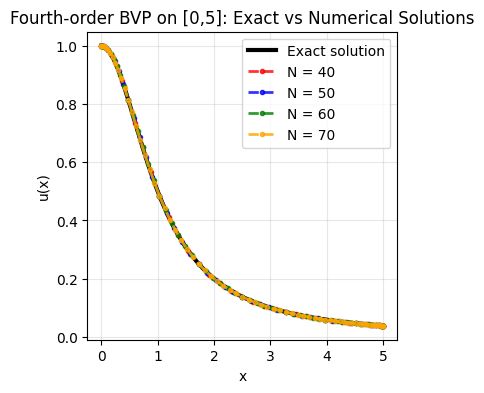

In [11]:
N_values_p6 = [40, 50, 60, 70]
solutions_p6 = {}

print("Solving for different N values:")
print("N\tu(0)\t\tu(5)\t\tMax Error")
print("-" * 50)

for N in N_values_p6:
    z_cheb, u_cheb = solve_fourth_order_bvp_p6(N)
    solutions_p6[N] = (z_cheb, u_cheb)
    
    # compute error
    u_exact_vals = u_exact_p6(z_cheb)
    max_error = np.max(np.abs(u_cheb - u_exact_vals))
    
    print(f"{N:2d}\t{u_cheb[-1]:.6f}\t{u_cheb[0]:.6f}\t{max_error:.2e}")

fig, ax = plt.subplots(figsize=fig_size)

# exact solution on fine grid
z_fine = np.linspace(0, 5, 1000)
u_exact_fine = u_exact_p6(z_fine)
ax.plot(z_fine, u_exact_fine, 'k-', linewidth=3, label='Exact solution')

# numerical solutions
colors = ['red', 'blue', 'green', 'orange']
for i, N in enumerate(N_values_p6):
    z_cheb, u_cheb = solutions_p6[N]
    ax.plot(z_cheb, u_cheb, '--', color=colors[i], linewidth=2, 
            label=f'N = {N}', alpha=0.8, marker='o', markersize=3)

ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Fourth-order BVP on [0,5]: Exact vs Numerical Solutions')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig("Figures/Fourth_order_BVP_p6_solutions.pdf", bbox_inches='tight')
plt.show()


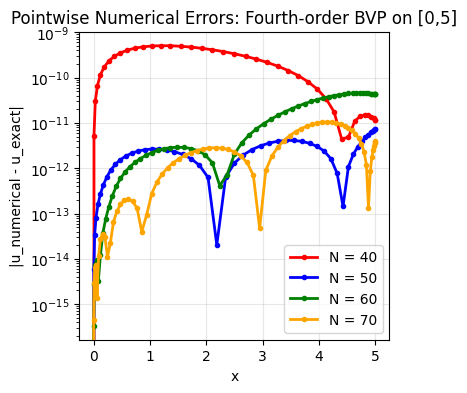

In [12]:
fig, ax = plt.subplots(figsize=fig_size)

for i, N in enumerate(N_values_p6):
    z_cheb, u_cheb = solutions_p6[N]
    u_exact_vals = u_exact_p6(z_cheb)
    error = np.abs(u_cheb - u_exact_vals)
    ax.semilogy(z_cheb, error, color=colors[i], linewidth=2, 
                marker='o', markersize=3, label=f'N = {N}')

ax.set_xlabel('x')
ax.set_ylabel('|u_numerical - u_exact|')
ax.set_title('Pointwise Numerical Errors: Fourth-order BVP on [0,5]')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig("Figures/Fourth_order_BVP_p6_errors.pdf", bbox_inches='tight')
plt.show()


Convergence analysis:
N	Max Error		Reduction Factor
---------------------------------------------
 8	1.75e-01		N/A
12	5.96e-03		29.4
16	3.41e-04		17.5
20	9.71e-05		3.5
24	1.06e-05		9.2
28	6.19e-07		17.1
32	1.14e-08		54.4
36	3.93e-09		2.9
40	5.07e-10		7.8
44	3.54e-11		14.3
48	2.20e-11		1.6
52	2.19e-11		1.0
56	2.53e-11		0.9
60	4.61e-11		0.5
64	5.62e-11		0.8
68	3.75e-11		1.5
72	6.03e-11		0.6
76	2.07e-10		0.3
80	2.37e-10		0.9


/var/folders/5w/g3bx6wq50fj4mfkz1519zz_80000gp/T/ipykernel_84322/539476744.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


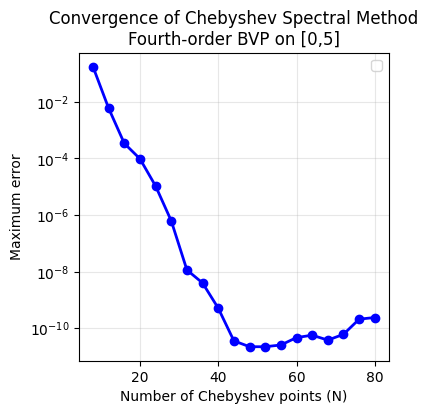

Machine precision not reached in the tested range N = 8 to 80
Minimum error achieved: 2.19e-11


In [13]:
N_range_p6 = np.arange(8, 81, 4)
max_errors_p6 = []

print("Convergence analysis:")
print("N\tMax Error\t\tReduction Factor")
print("-" * 45)

prev_error = None
for N in N_range_p6:
    try:
        z_cheb, u_cheb = solve_fourth_order_bvp_p6(N)
        u_exact_vals = u_exact_p6(z_cheb)
        max_error = np.max(np.abs(u_cheb - u_exact_vals))
        max_errors_p6.append(max_error)
        
        reduction_factor = prev_error / max_error if prev_error is not None else None
        reduction_str = f"{reduction_factor:.1f}" if reduction_factor is not None else "N/A"
        
        print(f"{N:2d}\t{max_error:.2e}\t\t{reduction_str}")

            
        prev_error = max_error
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"{N:2d}\tSolver failed: {str(e)[:30]}")
        max_errors_p6.append(np.nan)

# plot convergence
fig, ax = plt.subplots(figsize=fig_size)
valid_indices = ~np.isnan(max_errors_p6)
ax.semilogy(N_range_p6[:len(max_errors_p6)][valid_indices], 
            np.array(max_errors_p6)[valid_indices], 'bo-', linewidth=2, markersize=6)


ax.set_xlabel('Number of Chebyshev points (N)')
ax.set_ylabel('Maximum error')
ax.set_title('Convergence of Chebyshev Spectral Method\nFourth-order BVP on [0,5]')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig("Figures/Fourth_order_BVP_p6_convergence.pdf", bbox_inches='tight')
plt.show()

machine_precision_N = None
for i, error in enumerate(max_errors_p6):
    if not np.isnan(error) and error < 1e-14:
        machine_precision_N = N_range_p6[i]
        break

if machine_precision_N:
    print(f"Machine precision (≈ 1e-14) is achieved at N = {machine_precision_N}")
    print(f"The Chebyshev spectral method shows exponential convergence for this smooth problem.")
else:
    print(f"Machine precision not reached in the tested range N = {N_range_p6[0]} to {N_range_p6[-1]}")
    print(f"Minimum error achieved: {np.nanmin(max_errors_p6):.2e}")
